In [5]:
!pip install bt

In [6]:
!pip install yfinance

In [7]:
import bt
import yfinance as yf
import pandas as pd
import matplotlib

matplotlib.style.use("seaborn-darkgrid")
%matplotlib inline

<ipython-input-7-cfbd08e70d4d>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-darkgrid")


# Funcoes

In [8]:
def consulta_bc(codigo_bcb):

    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)

    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)

    df.set_index('data', inplace=True)

    return df

def cdi_acumulado(data_inicio, data_fim):

    cdi = consulta_bc(12)

    cdi_acumulado = (1 + cdi[data_inicio:data_fim] / 100).cumprod()
    cdi_acumulado.iloc[0] = 1

    return cdi_acumulado


In [9]:
inicio = "2018-01-01"
fim = "2023-12-31"

In [10]:
cdi = cdi_acumulado(data_inicio=inicio,data_fim=fim)

In [11]:
ativos = ["BPAC11.SA","ITUB3.SA","VALE3.SA","EGIE3.SA","WEGE3.SA"]

carteira = yf.download(ativos,start=inicio,end=fim)["Adj Close"]

[*********************100%%**********************]  5 of 5 completed


In [12]:
carteira["Renda Fixa"] = cdi
carteira.dropna(inplace=True)

In [32]:
carteira

Ticker,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA,renda_fixa
Date,,,,,,
2018-01-02,3.879362,19.145195,18.409054,27.350491,8.752854,1.000000
2018-01-03,3.916309,19.016563,18.552570,27.186600,8.619923,1.000529
2018-01-04,3.930677,18.770016,18.758293,27.298044,8.535962,1.000794
2018-01-05,3.995665,18.866489,18.887457,27.724174,8.570943,1.001058
2018-01-08,4.044626,18.973686,18.782206,28.340401,8.640909,1.001323
...,...,...,...,...,...,...
2023-12-21,36.511269,44.422287,27.029528,76.970001,36.088661,1.533895
2023-12-22,36.650700,44.570000,27.241220,76.389999,36.207664,1.534566
2023-12-26,37.138714,44.790001,27.558762,76.660004,36.415928,1.535237


# Backtesting


In [25]:
carteira.rename(columns={'Renda Fixa': 'renda_fixa'}, inplace=True)


In [33]:
carteira.columns = carteira.columns.str.rstrip(".SA")

In [53]:

rebalanceamento = bt.Strategy('rebalanceamento',
                                [bt.algos.RunMonthly(run_on_end_of_period=True),
                                 bt.algos.SelectAll(),
                                 bt.algos.CapitalFlow(1000), #APORTES
                                 bt.algos.WeighSpecified(BPAC11=0.1, EGIE3=0.1, ITUB3=0.1,VALE3=0.1, WEGE3=0.1, renda_fixa=0.5),
                                 bt.algos.Rebalance()])


In [54]:
buy_hold = bt.Strategy('Buy&Hold',
                            [bt.algos.RunOnce(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighEqually(),
                             bt.algos.Rebalance()])

In [55]:
    # Realiza o backtest das duas estratégias
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[["BPAC11","ITUB3","VALE3","EGIE3","WEGE3"]])

In [56]:
    # Obtém os resultados do backtest
resultados = bt.run(bt1, bt2)

# Resultados


In [57]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2018-01-01         2018-01-01
End                  2023-12-28         2023-12-28
Risk-free rate       0.00%              0.00%

Total Return         157.37%            310.70%
Daily Sharpe         1.40               1.00
Daily Sortino        2.25               1.59
CAGR                 17.10%             26.61%
Max Drawdown         -19.57%            -43.93%
Calmar Ratio         0.87               0.61

MTD                  3.70%              6.52%
3m                   9.25%              15.97%
6m                   11.24%             17.59%
YTD                  18.36%             26.22%
1Y                   18.04%             24.96%
3Y (ann.)            10.56%             10.22%
5Y (ann.)            17.53%             27.54%
10Y (ann.)           -                  -
Since Incep. (ann.)  17.10%             26.61%

Daily Sharpe         1.40               1.00
Daily Sor

<Axes: title={'center': 'Equity Progression'}>

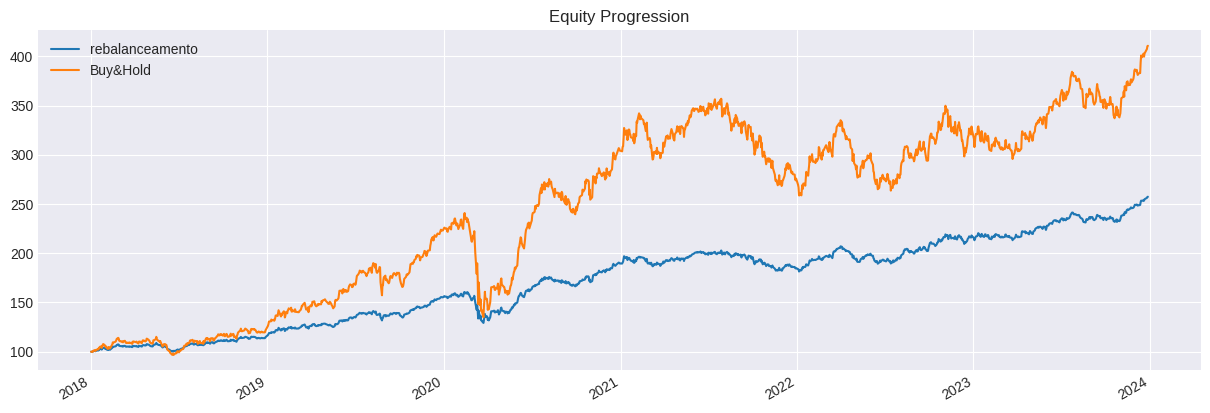

In [58]:
resultados.plot()

In [59]:
resultados.get_transactions()

price  quantity
Date       Security                       
2018-01-02 BPAC11       3.879362   25803.0
           EGIE3       19.145195    5228.0
           ITUB3       18.409054    5437.0
           VALE3       27.350491    3659.0
           WEGE3        8.752854   11436.0
...                          ...       ...
2023-11-30 EGIE3       43.326672    -234.0
           ITUB3       25.495798   -1084.0
           VALE3       73.849998     -51.0
           WEGE3       33.839176     212.0
           renda_fixa   1.523624   44855.0

[432 rows x 2 columns]

In [60]:
resultados.get_security_weights()

,BPAC11,EGIE3,ITUB3,VALE3,WEGE3,renda_fixa
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.099999,0.099991,0.099990,0.099975,0.099998,0.500000
2018-01-03,0.101032,0.099398,0.100850,0.099455,0.098557,0.500662
2018-01-04,0.101425,0.098131,0.101990,0.099885,0.097619,0.500904
2018-01-05,0.102591,0.098147,0.102184,0.100942,0.097533,0.498556
...,...,...,...,...,...,...
2023-12-21,0.101143,0.099860,0.103258,0.101510,0.103874,0.490317
2023-12-22,0.101395,0.100060,0.103930,0.100612,0.104079,0.489885
2023-12-26,0.102313,0.100131,0.104699,0.100543,0.104237,0.488038
2023-12-27,0.102658,0.100749,0.104880,0.101124,0.104176,0.486376


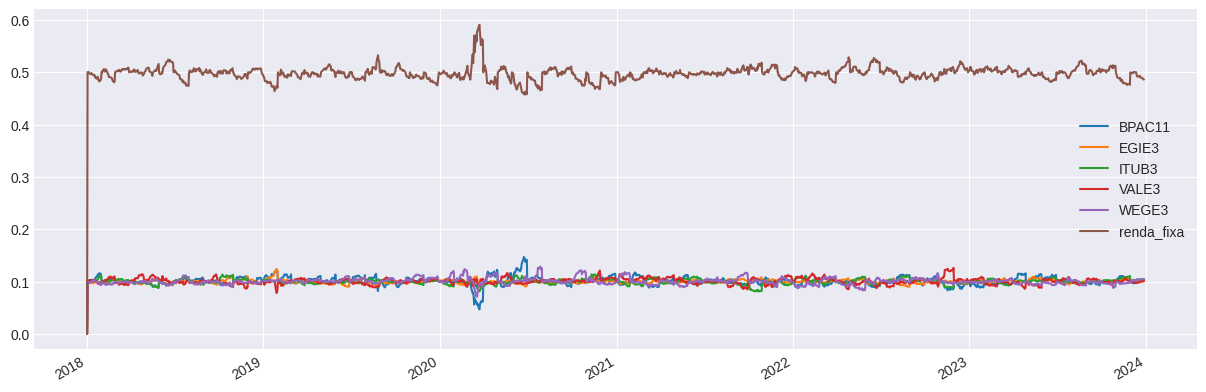

In [61]:
resultados.plot_security_weights()